# Affects in Tweets - Twitter Sentiment Analysis

- André Rocha, FEUP, up201706462@fe.up.pt
- Tito Griné, FEUP, up201706732@fe.up.pt
- Vítor Ventuzelos, FEUP, up201706403@fe.up.pt

## Introduction
Twitter sentiment analysis has become a common method to monitor the public's opinion regarding a given matter (either their brand, their business, etc). It is known such an analysis has very noticeable differences towards other sentiment analysis challenges: Twitter's messages, usually called Tweets, has a very noisy nature. Starting off the fact that it only allows 140 characters, which leads to several abbreviations and irregular expressions, it is also a space where slang is very common. These cases lead to a very high level of data sparsity.

Having to face such an issue, it is common to resort to stopwords to reduce textual noise. Due to its irregular contractions and slang, using pre-compiled stopwords lists have a negative impact, due to their inabilities to keep to up to date with new terms and information. It has been shown though, that dynamically generated stopwords lists increase greatly accuracies (Saif et.al 2014).

It is also common for emojis to be used in tweets. It is common to remove them as a whole, as well as attribute a sentiment to it or express it by a single word.

There also very common recognizable noise patterns that are commonly removed from tweet such as: hashtags ('#'), URLs, and repeated letters. These usually tend to have a negative impact by themselves.

Due to the common use of slang, contractions and even misspelling, the substitution of these by their more *formal* versions is usually explored, once again to further reduce data sparsity.

All of these methods explained above, and some common approaches NLP problems such as lemmatization and stemming, will be explored. A simple baseline method using only a Tokenizer will be used to compare against the others. Furthermore, several different Classifiers will be explored, such as [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), [Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm), [Multi-layer Perceptron Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and [1D Convolutional Neural Network](https://keras.io/examples/imdb_cnn/).

In [1]:
from datasets.process_dataset import process_dataset
data1 = process_dataset("datasets/trains.txt")
data2 = process_dataset("datasets/dev.txt")
data3 = process_dataset("datasets/test.txt")
data = data1 + data2 + data3

## Dataset Analysis
It was first made an analysis on the quality of the dataset of the SemEval2018 challenge. This was relevant to understand some problems that this would give us, such as the fact that the dataset is very small or that the class distribution is not particularly even.

### Class Distribution
It was first done a class distribution analysis, in order to perceive how balanced was our sample. It is clear to see the distribution was quite uneven between all of the classes, which created a new need: to test the use of oversampling, which will be discussed later. Something that also stands out is the fact the number of samples of this dataset is quite small, which led us to believe solutions based on Word Embeddings (such as our Convolutional Neural Network).

Such results perceived baseline results which would be much lower than expected, especially when it came to such a classification using such a small dataset. It was also considered to be considered the reduction of the number of labels. Most work seen in the area had indeed resorted mostly to binary classification (in positive or negative) or to tertiary classification (positive, negative or neutral).


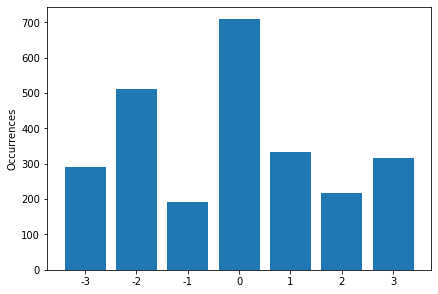

In [2]:
import numpy as np
import matplotlib.pyplot as plt

classes = {}
for t in data:
    classes[t.intensity] =  classes.get(t.intensity, 0) + 1

objects = sorted(classes.keys())
y_pos = np.arange(len(objects))
values = list(map(lambda key: classes[key], objects))

plt.bar(y_pos, values)
plt.xticks(y_pos, objects)
plt.ylabel('Occurrences')
plt.tight_layout(0.4)
plt.savefig('intensity_analysis.png')
plt.show()

### TF-IDF Distribution

It was then decided to assert the quality of the Tweets in the dataset. With the TF-IDF distribution, we are able to assert the amount of times words are repeated throughout the dataset. It is shown below this information using a Scatter Plot.

From the amount of words whose TF-IDF is near zero, it is clear that most words do not show up more than once in the whole dataset. This gave us the knowledge that most information would be removed from Tweets if we were to use the dynamic stopwords list generation method TF1, whose goal is to remove all words who only show up once in the whole dataset.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = map(lambda x: x.tweet, data)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(corpus)

tfidf_mean = tfidf_vectorizer_vectors.mean(axis=0).tolist()[0]

# get the first vector out (for the first document)

# place tf-idf values in a pandas data frame
plt.figure(figsize=(10,4))
plt.scatter(tfidf_vectorizer.get_feature_names(), tfidf_mean, s=5)
plt.ylabel('TF-IDF Value')
plt.savefig('tf_idf.png')
plt.show()

### Wordcloud
Even though a wordcloud does not represent any new information regarding what has been shown before, it is an interesting way to look at the words existing in the dataset. It also allowed us to understand how common it was to see the use of the ampersand, which made us understand that it was vital to remove some html references that were still in the dataset.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

corpus = map(lambda x: x.tweet, data)
count_vectorizer = CountVectorizer()
count_vectorizer_vectors = count_vectorizer.fit_transform(corpus)
word_count = count_vectorizer_vectors.sum(axis=0).tolist()[0]

features = count_vectorizer.get_feature_names()
cloud_words = ""
for i in range(0, len(word_count)):
    for _ in range(0, word_count[i]):
        cloud_words += features[i] + " "

wordcloud = WordCloud(width=1280, height=920, background_color='white', stopwords=STOPWORDS, collocations=False).generate(cloud_words)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')
plt.show()

## Approach Analysis
In this section, it will be analyzed all the parameters existing throughout the training process. It will specifically focus on these sections:
- Dataset unevenness analysis - analysis on how the label unevenness will affect the quality of the results.
- Classifier quality analysis - analysis on different classifiers, in order to detect the best one for this problem.
- Pre-processing analysis - analysis on the inclusion of several different steps to the pipeline


### Dataset Unevenness
It had been show during the dataset analysis, how considerable was the difference between the labels in the dataset. In this section, it will be shown that impact, by reducing the number of labels.

The original dataset had the label range of [-3, 3], being -3 the most negative possible label and 3 the most positive label. This will be tested against the range of [-1, 1] (i.e. if a tweet is negative, neutral or positive), and with the range of [0, 1] (i.e. if a tweet is positive or not).

For this test, a very simple pre-processing will be done: Tokenization, followed by a TF-IDF Vectorization and then classifcation. A Multinomial Naive Bayes classifier will be used for their classification, due to their simplicity and relatively good results in most NLP problems.

In [2]:
from pipelines.basic import basic_pipeline
from datasets.process_dataset import get_dataset
from sklearn.naive_bayes import MultinomialNB
from datasets.process_dataset import process_valence_for_2, process_valence_for_3


x, y = get_dataset(data)
y_3 = list(map(lambda valence: process_valence_for_3(valence), y))
y_2 = list(map(lambda valence: process_valence_for_2(valence), y))

clsf = MultinomialNB()
clsf_3 = MultinomialNB()
clsf_2 = MultinomialNB()
y_test, y_pred  = basic_pipeline(x, y, clsf)
y_test_3, y_pred_3  = basic_pipeline(x, y_3, clsf)
y_test_2, y_pred_2  = basic_pipeline(x, y_2, clsf)


Using TensorFlow backend.


              precision    recall  f1-score   support

          -3       0.30      0.52      0.38        54
          -2       0.37      0.23      0.28       110
          -1       0.19      0.42      0.27        31
           0       0.40      0.18      0.24       154
           1       0.23      0.21      0.22        57
           2       0.15      0.27      0.20        44
           3       0.36      0.50      0.42        64

    accuracy                           0.29       514
   macro avg       0.29      0.33      0.29       514
weighted avg       0.33      0.29      0.28       514

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       210
           1       0.65      0.65      0.65       158
           2       0.43      0.48      0.45       146

    accuracy                           0.60       514
   macro avg       0.59      0.59      0.59       514
weighted avg       0.61      0.60      0.60       514

              precisio

With the result of this graphic, it is possible to observe the effect of reducing the number of labels. With this data, it was fair to assume it would be better to reduce the number of labels to **three** due to the outstanding increase in all scores, and the better compromis (since two labels was considered to be more lacking in terms on the knowledge that came out of the model). Therefore, it is important to refer how **all results from this point forward will be presented with 3 labels**.


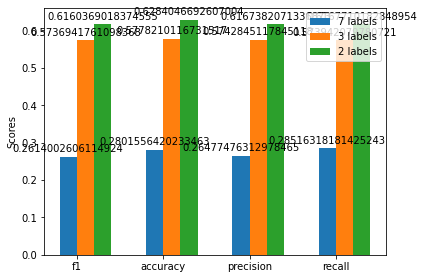

In [3]:
from scoring import build_comparison_graph, get_scores
f1, acc, precision, recall = get_scores(y_test, y_pred)
f1_3, acc_3, precision_3, recall_3 = get_scores(y_test_3, y_pred_3)
f1_2, acc_2, precision_2, recall_2 = get_scores(y_test_2, y_pred_2)

build_comparison_graph(["f1", "accuracy", "precision", "recall"], [[f1, acc, precision, recall], [f1_3, acc_3, precision_3, recall_3], [f1_2, acc_2, precision_2, recall_2]], ["7 labels", "3 labels", "2 labels"])

### Classifier Quality
In order to better understand which one is the best classifier, it will be compared the use of several different classifiers, in order to better understand which one is able to have better results for our solution.

It is important to notice that all of these classifiers have suffered hyperparameter optimization beforehand in order to bring out the best results possible from them and reduce the number of comparisons brought to the table. Furthermore, tests will be done in the same pipeline used in unevenness analysis.

Based on that, the chosen classifiers and their respective parameters are the following:
 - Multinomial Naive Bayes - with alpha (addictive smoothing parameter) of 1.0
 - Support Vector Classifier - with a linear kernel, using  a shrinking heuristic
 - Linear Support Vector Classifier - with the hinge loss function (the one used in the Support Vector Classifier)
 - Multi-layer Perceptron - With relu as its activation function, lbfgs as the weight optimization solver (due to its capacity with smaller datasets).
 - 1D Convolutional Neural Network - network with an initial embedding layer, followed by a dropout with a rate of 0.42, followed by a 1D convolutional layer with 500 filters and a kernel size of 3, and relu as its activation function. It is then followed by a Global Max Pooling and two Dense layers: one with 500 units and the ending layer with the number of outputs. It uses adam as its weight optimization solver.

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from classifiers.cnn import CNN
from pipelines.basic import basic_pipeline


naive = MultinomialNB()
svc = SVC(kernel='linear')
linear_svc = LinearSVC(loss='hinge')
nn = MLPClassifier(solver='lbfgs')
cnn = CNN(dropout_rate=0.42, filters=500, units=500, epochs=4)

naive_pred = basic_pipeline(x, y_3, naive)
svc_pred = basic_pipeline(x, y_3, svc)
linear_svc_pred = basic_pipeline(x, y_3, linear_svc)
nn_pred = basic_pipeline(x, y_3, nn)
cnn_pred = basic_pipeline(x, y_3, cnn)

naive_f1, naive_acc, naive_precision, naive_recall = get_scores(y_test_3, naive_pred)

svc_f1, svc_acc, svc_precision, svc_recall = get_scores(y_test_3, svc_pred)

linear_svc_f1, linear_svc_acc, linear_svc_precision, linear_svc_recall = get_scores(y_test_3, linear_svc_pred)

nn_f1, nn_acc, nn_precision, nn_recall = get_scores(y_test_3, nn_pred)

cnn_f1, cnn_acc, cnn_precision, cnn_recall = get_scores(y_test_3, cnn_pred)


build_comparison_graph(["f1", "accuracy", "precision", "recall"], [[naive_f1, naive_acc, naive_precision, naive_recall],[svc_f1, svc_acc, svc_precision, svc_recall],[linear_svc_f1, linear_svc_acc, linear_svc_precision, linear_svc_recall],[nn_f1, nn_acc, nn_precision, nn_recall],[cnn_f1, cnn_acc, cnn_precision, cnn_recall],], ["Naive Bayes", "SVC", "Linear SVC", "MLP", "CNN"])

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       204
           1       0.69      0.63      0.66       184
           2       0.37      0.45      0.41       126

    accuracy                           0.60       514
   macro avg       0.59      0.58      0.58       514
weighted avg       0.62      0.60      0.60       514

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       187
           1       0.73      0.60      0.66       179
           2       0.48      0.43      0.45       148

    accuracy                           0.59       514
   macro avg       0.59      0.58      0.58       514
weighted avg       0.60      0.59      0.59       514

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       211
           1       0.67      0.70      0.69       185
           2       0.33      0.34      0.33       118

    accuracy        

/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

From the shown results, it it clear how much the first 4 classifiers are close to each other, with naive bayes having a slightly better accuracy surprisingly.

It is to no surprise that the convolutional neural network has weak results compared to the other classifiers, due to the size of the dataset, which does not assure enough data to properly train it. This proves that there would be interest in testing further data generation and augmentation techniques, in order to obtain an even bigger dataset.

Given these results, it is safe to assume that the use of Naive Bayes for the rest of the analysis will bring out the best results, since it is the most simple classifier as well as the one who tends to be more susceptible to pre-processing.

## References
1. A. Kunwar, [Twitter Sentiment Analysis GUI](https://github.com/akbloodadarsh/Twitter-Sentimental-Analysis)
2. C. Alcantara and J. Cassiano, [Social Network Sentiment Analysis](https://github.com/cassio-all/sentimental_analysis_twitter)
3. C. Baziotis, [SemEval 2018](https://github.com/cbaziotis/ntua-slp-semeval2018)
4. S. Doshi, [Twitter Sentiment Analysis using fastText](https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597)
5. Hassan S., Miriam F., Yulan H. and Harith, A,  ["On Stopwords, Filtering and Data Sparsity for Sentiment Analysis of Twitter"](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf), 2014
6. Z. Jianqiang and G. Xiaolin, ["Comparison Research on Text Pre-processing Methods on Twitter Sentiment Analysis"](https://ieeexplore.ieee.org/abstract/document/7862202), 2017
7. A. Severyn and A. Moschitti, ["Twitter Sentiment Analysis with Deep Convolutional Neural Networks"](https://dl.acm.org/doi/abs/10.1145/2766462.2767830), 2015
